In this example we are using the featues of *finde-peaks()* to determine the left and right integration limits to integrate peaks of an example chromatogram.

To achieve this, we first have to reduce the noise and apply a baseline correction.

Let's start by loading the file!

In [ ]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False
if USE_COLAB:
    from google.colab import files
    uploaded = files.upload()
else:
    # CHANGE THIS TO YOUR LOCAL PATH
    #path =  "../../data/exercises/Chromatography/"
    # path to github repo
    path = "https://raw.githubusercontent.com/stkroe/PythonForChemists/main/course/data/exercises/Chromatography/"


Saving Chromatogram.csv to Chromatogram.csv


We read out the data as before and (optionally) extract the x-axis as time *t* and the y-axis as intensity *I* :

In [6]:
import numpy as np

data = np.loadtxt("Chromatogram.csv", delimiter=',', skiprows = 1)

t = data[:,0]
I = data[:,1]

Procced as in the previous example:

- *gaussian_filtered1xd()* for the smoothing/denoising. Experiment with the *sigma* value to find the best setting.
- *minimum_filter1d()* calculates the baseline for correction. Experiment with the *size* parameter to find the best compromise.

Always plot the data or you will miss potential errors!

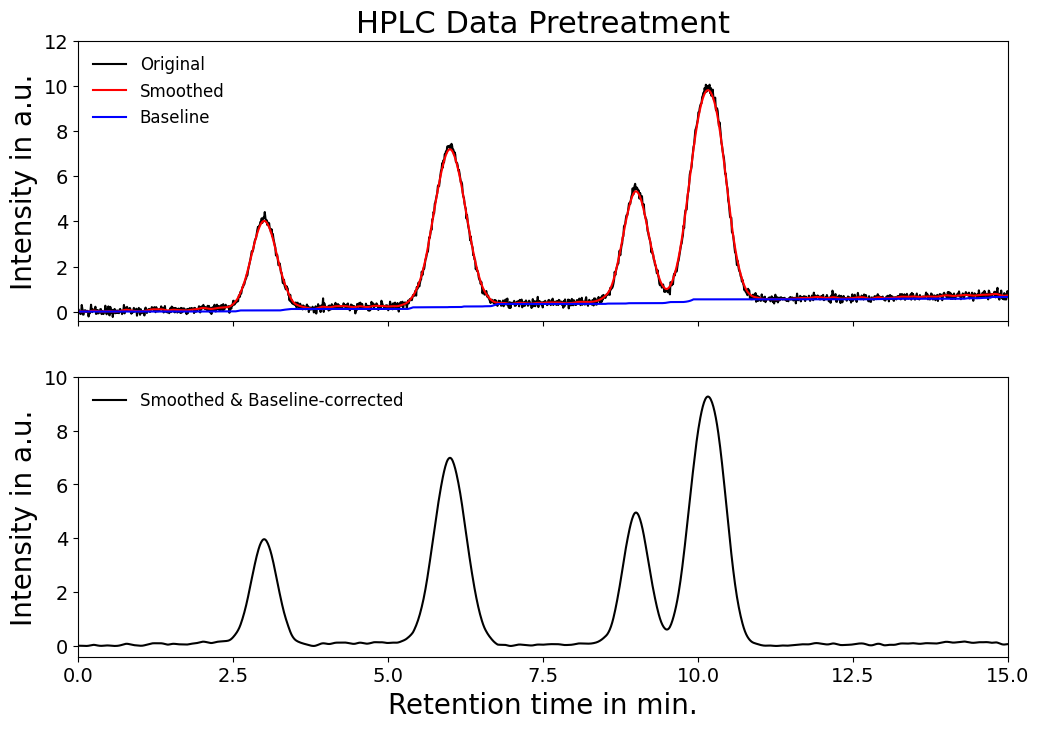

In [7]:
from scipy.ndimage import gaussian_filter1d, minimum_filter1d
import matplotlib.pyplot as plt

# Reducing the noise
I_smooth = gaussian_filter1d(I, sigma=5)

# Calculating and subtracting the baseline
baseline = minimum_filter1d(I_smooth, size=300)
I_corr = I_smooth - baseline

# Setup plots for validation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

ax1.plot(t, I, color='k', label = 'Original')
ax1.plot(t, I_smooth, color = 'r', label = 'Smoothed')
ax1.plot(t, baseline, color = 'b', label = 'Baseline')

ax2.plot(t, I_corr, color = 'k', label = 'Smoothed & Baseline-corrected')

for i in [ax1, ax2]:
  i.set_xlim(0, 15)
  i.tick_params(axis='both', labelsize=14)
  i.legend(loc='upper left', frameon=False, fontsize = 12)
  i.set_xticks(np.arange(0, 15.0001, step=2.5))

ax1.set_xticklabels([])
ax1.set_ylim(-0.4, 12)
ax2.set_ylim(-0.4, 10)

ax1.set_title('HPLC Data Pretreatment', fontsize=22)
ax1.set_ylabel('Intensity in a.u.', fontsize=20)
ax2.set_ylabel('Intensity in a.u.', fontsize=20)
ax2.set_xlabel('Retention time in min.', fontsize=20)

plt.show()

Now we can simply apply find peaks again.

This time we make use of the *info* object, that is a python dictionary containing additional information about the peaks.

We are interested in the left and right base of the individual peaks.


<u>However:</u> By default, the detection of the bases is quite unreliable, especially if there are "problematic" peaks such as the two on the right.

array([0.5903936 , 3.80253502, 6.97464977, 6.97464977])

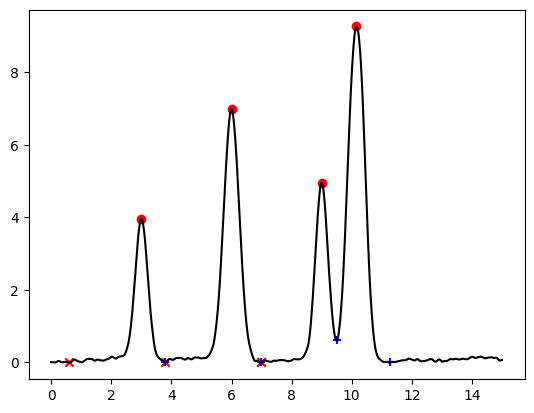

In [8]:
from scipy.signal import find_peaks

peaks, info = find_peaks(I_corr, prominence=0.20)

# Extract information from the info dictionary
left_bases  = info['left_bases']
right_bases = info['right_bases']

# Plot the chromatogram and the detected peaks
plt.plot(t, I_corr, color='k')
plt.scatter(t[peaks], I_corr[peaks], color='red')

# Using the information about the bases we show the left bases as red x
# and the right bases as blue +
plt.scatter(t[left_bases], I_corr[left_bases], marker = 'x', color='red')
plt.scatter(t[right_bases], I_corr[right_bases], marker = '+', color='blue')

# In additon we plot the time corresponding to the left bases which are
# the problems in this case
t[left_bases]


To fine tune the detection of the bases, we use *peak_widths()*

Here we can adjust the relative heights to determine reasonable integration limits. This provides us with a much more reliable autodetection of the bases.

If required, one can always execute the command *peak_widths()* several times, *e.g.* to get different detection for the two peaks on the left side.

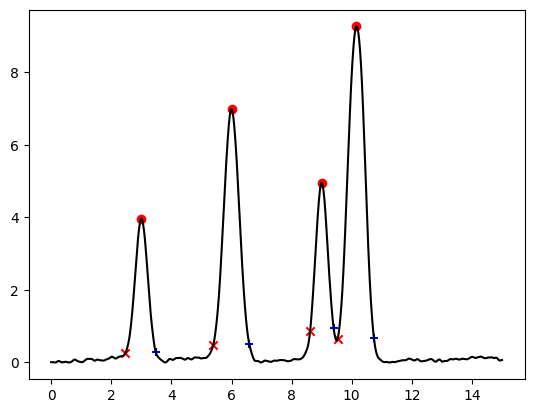

In [9]:
from scipy.signal import peak_widths

widths, peak_heights, left_ips, right_ips,  = peak_widths(I_corr, peaks, rel_height=0.93)

plt.plot(t, I_corr, color='k')
plt.scatter(t[peaks], I_corr[peaks], color='red')
plt.scatter(t[left_ips.astype(int)], I_corr[left_ips.astype(int)], marker = 'x', color='red')
plt.scatter(t[right_ips.astype(int)], I_corr[right_ips.astype(int)], marker = '+', color='blue')

To obtain the peak area, we apply the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) using the left and right bases determined above.

In addition, we also calculate the width at the detected base.

We generate an output but also store the area for future use.

In [10]:
# Get the number of detected peaks
n_peaks = len(peaks)

# Setup the array area
area = np.zeros(n_peaks)

print("----------------------------------------------------------------------")
print("                 Ret. Time / min.    Area / a.u.·min.    Width / min.")
print("-----------------------------------------------------------------------")

# Loop over all peaks to carry out the integration
# Careful: In order for the integration to work, we need to transfer the
# determined left and right bases to integer values using .astype(int)
for p in range(n_peaks):
  left = left_ips[p]
  right = right_ips[p]
  width = t[right.astype(int)] - t[left.astype(int)]
  area[p] = np.trapezoid(I[left.astype(int):right.astype(int)], t[left.astype(int):right.astype(int)])
  print(f'Peak {p+1:2d} of {n_peaks:2d}:     {t[peaks[p]]:8.3f}            {area[p]:8.3f}         {width:8.3f}')

print("----------------------------------------------------------------------")

----------------------------------------------------------------------
                 Ret. Time / min.    Area / a.u.·min.    Width / min.
-----------------------------------------------------------------------
Peak  1 of  4:        3.002               2.123            1.011
Peak  2 of  4:        6.004               4.659            1.201
Peak  3 of  4:        8.996               2.731            0.781
Peak  4 of  4:       10.157               6.806            1.211
----------------------------------------------------------------------


Now that we have the areas, we can generate a final graphic.

Here, we shade the integration area and use both peak position and area as label.

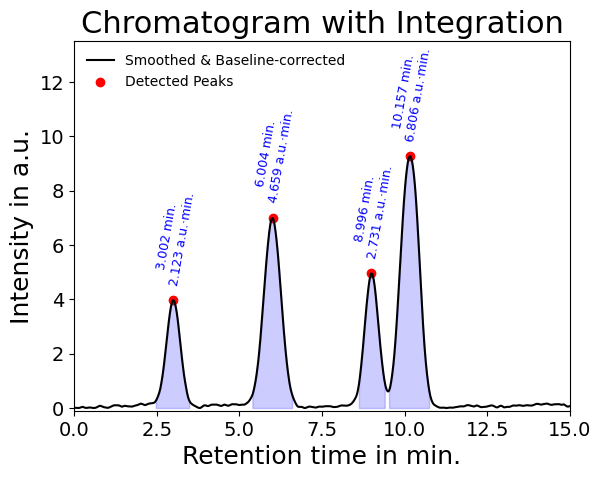

In [11]:
plt.plot(t, I_corr, color='k', label = 'Smoothed & Baseline-corrected')
plt.scatter(t[peaks], I_corr[peaks], color='red', label='Detected Peaks')

# Loop over all peaks to add the fill effect and label the peaks with
# the respective retention time and area
for p in range(n_peaks):
  left = left_ips[p]
  right = right_ips[p]
  plt.fill_between(t, I_corr, where=(t >= t[left.astype(int)]) & (t <= t[right.astype(int)]), color='b', alpha=0.2)
  plt.text(t[peaks[p]], I_corr[peaks[p]] + 0.05, f"    {t[peaks[p]]:.3f} min.\n    {area[p]:.3f} a.u.·min.",
             fontsize=9, ha='center', color='blue', rotation=80)

# Set upt the plot
plt.xlim(0, 15)
plt.ylim(-0.1, 13.5)

# Add lables and titles, select font size
plt.xlabel(r'Retention time in min.', fontsize=18)
plt.ylabel('Intensity in a.u.', fontsize=18)
plt.title('Chromatogram with Integration', fontsize=22)

# Increase font size of axis labels
plt.tick_params(axis='both', labelsize=14)

plt.legend(loc='upper left', frameon=False)

plt.xticks(np.arange(0, 15.0001, step=2.5))

plt.show()
